# Imports

In [1]:
import pandas as pd
import numpy as np
import os,  sys
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from mpl_toolkits import mplot3d

sys.path.append('/Users/benjaminwong/JupyterNotebooks/masters_pfti/notebooks/python/')

from grouping import Grouping, Resource
import plotter

output_dir = "../outputs/het_analysis_pcbc/"
SAVE = False

%matplotlib widget

# Data Input and Cleaning

In [2]:
# we will run some heterogeneity calculations on the pcbc data in this notebook
FILE_LOC = '../data/ptfi_1/'
FILE_NAME = 'DP_block_grade estimates_actual tons_dp coordinate.xlsx'

GIF_SAVE_LOC = '../outputs/gifs/'

draw_tons = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Drawn Tons')
cu_pcbc = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Cu_PCBC')
au_pcbc = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Au_PCBC')
dp_coords = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='DP_Coordinates')

In [3]:
names = {
    'Draw Point Name': 'name'
}

cols = list(draw_tons.columns)
for col_name in cols:
    if isinstance(col_name, dt.datetime):
        names[col_name] = f'{col_name.year}_{col_name.month}'
        
draw_tons = draw_tons.rename(
    columns = names
)

draw_tons = draw_tons.set_index('name').astype(float)

In [4]:
names = {
    'Draw Point Name': 'name',
    44835: '2022_10'
}

cols = list(cu_pcbc.columns)
for col_name in cols:
    if isinstance(col_name, dt.datetime):
        names[col_name] = f'{col_name.year}_{col_name.month}'
        
cu_pcbc = cu_pcbc.rename(
    columns = names
)

cu_pcbc = cu_pcbc.set_index('name').astype(float)

In [5]:
names = {
    'Draw Point Name': 'name'
}

cols = list(au_pcbc.columns)
for col_name in cols:
    if isinstance(col_name, dt.datetime):
        names[col_name] = f'{col_name.year}_{col_name.month}'
        
au_pcbc = au_pcbc.rename(
    columns = names
)

au_pcbc = au_pcbc.set_index('name').astype(float)

In [6]:
months = list(draw_tons.columns)
dhids = list(draw_tons.index)

In [7]:
draw_tons.replace(0, np.nan, inplace=True)

In [8]:
for dhid in dhids:
    for month in months:
        if draw_tons[month][dhid] is np.nan:
            if au_pcbc[month][dhid] != 0:
                print(f"au_pcbc at {dhid} {month} is {au_pcbc[month][dhid]}")
        # else:
        #     if cu_pcbc[month][dhid] == 0:
        #         print(f"cu_pcbc at {dhid} {month} is {cu_pcbc[month][dhid]}")
            

In [9]:
groups = {}

for dhid in dhids:
    weights = draw_tons.loc[dhid]
    if weights.isnull().all():
        print(f"No data for {dhid}")
    else:
        groups[dhid] = Grouping(dhid)
        # Add CU
        groups[dhid].add_resource("CU", weights, cu_pcbc.loc[dhid])
        # Add AU
        groups[dhid].add_resource("AU", weights, au_pcbc.loc[dhid])

No data for P04-11W
No data for P04-12W
No data for P04-13W
No data for P04-14W
No data for P04-15W
No data for P05-08W
No data for P05-09W
No data for P05-10W
No data for P05-11E
No data for P05-11W
No data for P05-12E
No data for P05-12W
No data for P05-13E
No data for P05-13W
No data for P05-14E
No data for P05-14W
No data for P05-15E
No data for P05-15W
No data for P05-16W
No data for P05-17W
No data for P05-18W
No data for P05-19W
No data for P05-20W
No data for P06-07W
No data for P06-08E
No data for P06-08W
No data for P06-09E
No data for P06-09W
No data for P06-10E
No data for P06-10W
No data for P06-11E
No data for P06-11W
No data for P06-12E
No data for P06-12W
No data for P06-13E
No data for P06-13W
No data for P06-14E
No data for P06-14W
No data for P06-15E
No data for P06-15W
No data for P06-16E
No data for P06-16W
No data for P06-17E
No data for P06-17W
No data for P06-18E
No data for P06-18W
No data for P06-19E
No data for P06-19W
No data for P06-20E
No data for P06-20W


In [10]:
len(groups)

398

In [11]:
groups['P08-04W'].resources['CU'].get_heterogeneity()

0.0464221476730414

# Output

Output G-R Graphs

In [12]:
import matplotlib.pyplot as plt

elements = [
    'CU',
    'AU'
]

if SAVE:
    fig = plt.figure()
    fig.set_size_inches(8, 8)


    for dhid, group in groups.items():
        save_loc = output_dir + f'{dhid}/'
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)

        for element in elements:
            fig.clear()
            ax = fig.add_subplot()

            het = group.resources[element].get_heterogeneity()
            df = group.resources[element].get_info()
            
            if len(df) > 0:
                ax.set_title(f'{dhid}_{element}_HET={het:.2f}')
                plotter.plot_grade_recovery_curve(ax, df, element)

                fig.savefig(save_loc + f'{dhid}_{element}.svg', format='svg')

In [13]:
# then we want to graph the mass yield curves for all the individual elements
no_of_graphs = len(elements)

if SAVE:
    fig = plt.figure()
    fig.set_size_inches(12, 12)

    s = 0.5
    alpha = 0.4

    for element in elements:
        fig.clear()
        ax = fig.add_subplot()
        ax_sec = ax.twinx()
        
        for dhid, drillhole in groups.items():
            if element in drillhole.resources:
                plotter.scatter_g_r(ax, ax_sec, drillhole.resources[element].get_info(), s=s, alpha=alpha)
                
        plotter.set_g_r_labels(ax, ax_sec, element)
        ax.set_title(f'master_{element}')

        save_loc = output_dir + f'master/'
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)
        fig.savefig(save_loc + f'master_{element}.png', format='png', dpi=200)

In [14]:
combined_data = Grouping('combined_data')
flat_draw_tons = draw_tons.to_numpy().flatten()
combined_data.add_resource("CU", flat_draw_tons, cu_pcbc.to_numpy().flatten())
combined_data.add_resource("AU", flat_draw_tons, au_pcbc.to_numpy().flatten())

In [15]:
if SAVE:
    fig = plt.figure()
    fig.set_size_inches(8, 8)

    for element in elements:
        fig.clear()
        ax = fig.add_subplot()

        het = combined_data.resources[element].get_heterogeneity()
        df = combined_data.resources[element].get_info()
            
        if len(df) > 0:
            ax.set_title(f'combined_{element}_HET={het:.2f}')
            plotter.plot_grade_recovery_curve(ax, df, element)

            save_loc = output_dir + f'combined/'
            if not os.path.exists(save_loc):
                os.makedirs(save_loc)
            fig.savefig(save_loc + f'combined_{element}.png', format='png', dpi=200)

# Visualize

In [16]:
dp_coords = dp_coords.rename(
    columns={
        "Draw Point Name": "name", 
        "X-dpt": "x",
        'Y-dpt': 'y',
        'Z-dpt': 'z'
    }
)
dp_coords = dp_coords.set_index('name')

In [17]:
for dhid, group in groups.items():
    if dhid not in list(dp_coords.index):
        print('dhid')

In [18]:
hs = {}
for dpid in list(dp_coords.index):
    if dpid not in groups:
        for element in elements:
            if element not in hs:
                hs[element] = []
            hs[element].append(np.nan)
    else:
        dp = groups[dpid]
        for element in elements:
            if element not in hs:
                hs[element] = []
            if element in dp.resources:
                dhr = dp.resources[element]
                hs[element].append(dp.resources[element].get_heterogeneity())
            else:
                hs[element].append(np.nan)

In [19]:
# %matplotlib qt


# fig = plt.figure()
# ax = plt.axes(projection='3d')

# element = 'CU'

# h = np.array(hs[element])

# # ax.scatter3D(
# #     dp_coords['x'], 
# #     dp_coords['y'], 
# #     dp_coords['z'],
# #     s=1,
# #     alpha=0.5,
# #     c='grey'
# # )
# # ax.set_title(element)
# # ax.set_xlabel('x')
# # ax.set_ylabel('y')
# # ax.set_zlabel('z')

# x, y, z = dp_coords['x'], dp_coords['y'], dp_coords['z']

# col = []
# # cmap = colors.Colormap('viridis')

# import matplotlib
# cmap = matplotlib.cm.get_cmap('viridis')

# ch = np.array(h)
# ch = ch[~np.isnan(ch)]
# percentile90 = np.quantile(ch, 0.97)
# print(percentile90)
# def normalize(i: float):
#     return i / percentile90

# for het in h:
#     if not np.isnan(het):
#         col.append(cmap(normalize(het)))
#     else:
#         col.append((0.7, 0.7, 0.7, 0.1))

# # col = np.where(np.isnan(h), 'red', h)
# # ma_h = np.ma.array(h, mask=np.isnan(h))
# # cmap = plt.get_cmap('viridis').copy()
# # cmap.set_bad('grey',1.)

# p = ax.scatter3D(
#     x, 
#     y,
#     z, 
#     c=col,
#     # cmap=cmap,
#     s=40,
#     alpha=1
# )
# ax.set_title(element)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# # ax.set_zlim([2550, 2650])
# fig.colorbar(p)

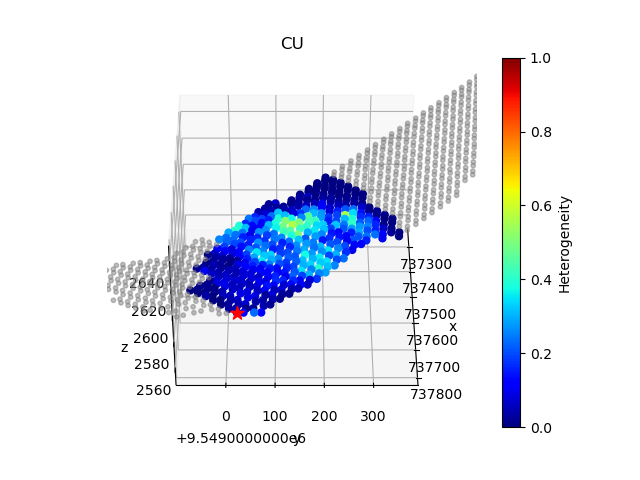

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')

element = 'CU'

h = np.array(hs[element])
x, y, z = dp_coords['x'], dp_coords['y'], dp_coords['z']

cmap = plt.colormaps.get('jet')
nan = np.argwhere(np.isnan(h))

p = ax.scatter3D(
    x, 
    y,
    z, 
    c=h,
    vmax=1,
    cmap=cmap,
    s=25,
    alpha=1
)

# Set limits to the non-nan values
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.set_zlim([2550, 2650])


nan = np.argwhere(np.isnan(h))
nan = nan.flatten()
ax.scatter3D(
    x[nan], 
    y[nan], 
    z[nan],
    s=10,
    alpha=0.5,
    c='grey'
)

ax.set_title(element)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.azim = 0
ax.elev = 40

id = 'P08-04W'
ax.scatter(x[id], y[id], z[id], marker='*', c='red', s=100)

cbar = fig.colorbar(p)
cbar.set_label('Heterogeneity')

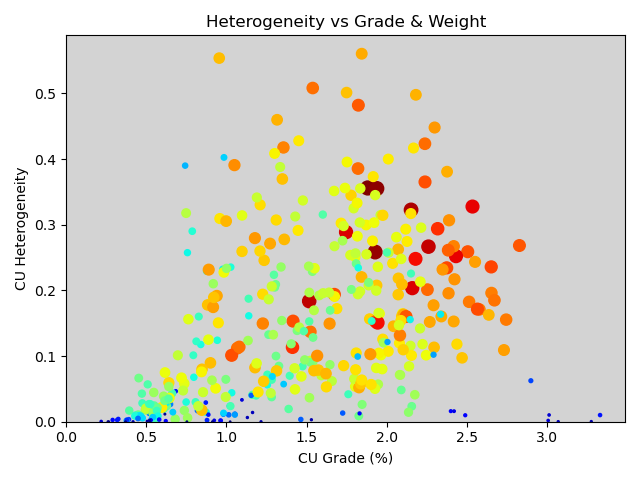

In [21]:
element = 'CU'

x, y, w = [], [], []

for dhid, group in groups.items():
    x.append(group.resources[element].get_grade())
    y.append(group.resources[element].get_heterogeneity())
    w.append(group.resources[element].get_cml_weight())
    
max_w = np.max(w)
scaled_w = 1 + (9 * (w / max_w))


fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x, y, s=scaled_w**2, c=w, cmap=plt.colormaps.get('jet'))

ax.set_xlabel(f'{element} Grade (%)')
ax.set_xlim(0, None)

ax.set_ylabel(f'{element} Heterogeneity')
ax.set_ylim(0, None)

ax.set_title('Heterogeneity vs Grade & Weight')
ax.set_facecolor('lightgrey')

fig.tight_layout()

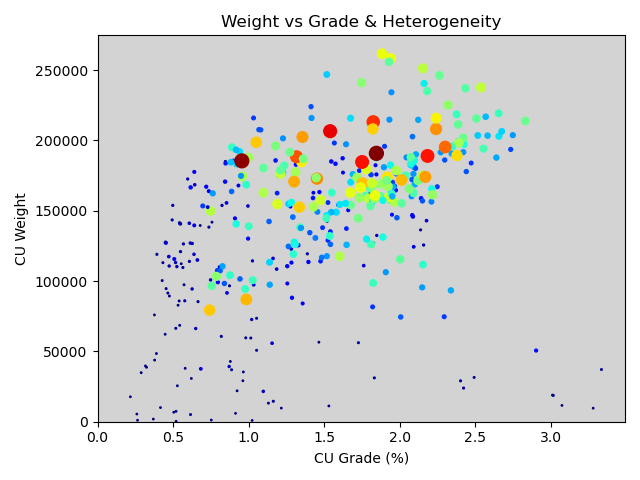

In [22]:
element = 'CU'

x, y, h = [], [], []

for dhid, group in groups.items():
    x.append(group.resources[element].get_grade())
    y.append(group.resources[element].get_cml_weight())
    h.append(group.resources[element].get_heterogeneity())
    
max_h = np.max(h)
scaled_h = 1 + (9 * (h / max_h))

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x, y, s=scaled_h**2, c=h, cmap=plt.colormaps.get('jet'))

ax.set_xlabel(f'{element} Grade (%)')
ax.set_xlim(0, None)

ax.set_ylabel(f'{element} Weight')
ax.set_ylim(0, None)

ax.set_title('Weight vs Grade & Heterogeneity')
ax.set_facecolor('lightgrey')

fig.tight_layout()